<a href="https://colab.research.google.com/github/mojtaba00ramezani/Transfer_Learning/blob/main/Transfer_Learning_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### بارگزاری پکیج های مورد نیاز




In [136]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import optimizers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# استفاده از TPU

In [137]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


# استفاده از GPU

In [138]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 0
/bin/bash: nvidia-smi: command not found


# تنظیم هایپرپارامتر ها

In [139]:
batch_size = 48
width = 224
height = 224
channels = 3
epochs = 10
dropout_rate = 0.2
input_shape = (height, width, channels)

# ایجاد شبکه EfficientNetB0 و imagenet

In [140]:
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# فریز کردن لایه های شبکه در مقابل یادگیری

In [141]:
for layer in effnet_base.layers[:-3]:
    layer.trainable = False

# بارگزاری دیتاست آهو و اسب و تنظیم داده های تست و آموزش و ارزیابی

In [142]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
filter_train = np.where((Y_train == 4) | (Y_train == 7))
X_train = X_train[filter_train[0]]
Y_train = Y_train[filter_train[0]]
filter_test = np.where((Y_test == 4) | (Y_test == 7))
X_test = X_test[filter_test[0]]
Y_test = Y_test[filter_test[0]]

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print('X_train shape: {0}, Y_train shape: {1} , X_test shape: {2}, Y_test shape: {3} , X_valid shape: {4}, Y_valid shape: {5} '.format(X_train.shape, Y_train.shape,X_test.shape, Y_test.shape,X_valid.shape, Y_valid.shape))

X_train shape: (8000, 32, 32, 3), Y_train shape: (8000, 1) , X_test shape: (2000, 32, 32, 3), Y_test shape: (2000, 1) , X_valid shape: (2000, 32, 32, 3), Y_valid shape: (2000, 1) 


In [143]:
def preprocess_image(image, label):
    resized_image = tf.image.resize(image, [width, height])
    img = tf.image.random_flip_left_right(resized_image)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.rot90(img)
    return img, label

# پیش پردازش داده های تست و یادگیری و ارزیابی

In [144]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_set = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

train_set = train_set.map(preprocess_image).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess_image).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess_image).batch(batch_size).prefetch(1)

# ساخت لایه های آخر شبکه یادگیری

In [145]:
conv2d = keras.layers.Conv2D(7, 7)(effnet_base.output, training=False)
bn = keras.layers.BatchNormalization()(conv2d)
gap = keras.layers.GlobalAveragePooling2D()(bn)
do = keras.layers.Dropout(dropout_rate)(gap)
flatten = keras.layers.Flatten()(do)
fc1 = keras.layers.Dense(512, activation='relu')(flatten)
output = keras.layers.Dense(10, activation='softmax')(fc1)

new_model = keras.Model(inputs=effnet_base.input, outputs=output)

In [146]:
for index, layer in enumerate(new_model.layers):
    print("Layer Index: {}, Trainable: {}, Layer Name : {} ".format(index, layer.trainable ,layer.name))

Layer Index: 0, Trainable: False, Layer Name : input_12 
Layer Index: 1, Trainable: False, Layer Name : rescaling_11 
Layer Index: 2, Trainable: False, Layer Name : normalization_11 
Layer Index: 3, Trainable: False, Layer Name : stem_conv_pad 
Layer Index: 4, Trainable: False, Layer Name : stem_conv 
Layer Index: 5, Trainable: False, Layer Name : stem_bn 
Layer Index: 6, Trainable: False, Layer Name : stem_activation 
Layer Index: 7, Trainable: False, Layer Name : block1a_dwconv 
Layer Index: 8, Trainable: False, Layer Name : block1a_bn 
Layer Index: 9, Trainable: False, Layer Name : block1a_activation 
Layer Index: 10, Trainable: False, Layer Name : block1a_se_squeeze 
Layer Index: 11, Trainable: False, Layer Name : block1a_se_reshape 
Layer Index: 12, Trainable: False, Layer Name : block1a_se_reduce 
Layer Index: 13, Trainable: False, Layer Name : block1a_se_expand 
Layer Index: 14, Trainable: False, Layer Name : block1a_se_excite 
Layer Index: 15, Trainable: False, Layer Name : blo

# ساخت تایع callback

In [147]:
def tensorboard_callback(directory, name):
    log_dir = directory + "/" + name
    t_c = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    return t_c

def model_checkpoint(directory, name):
    log_dir = directory + "/" + name
    m_c = tf.keras.callbacks.ModelCheckpoint(filepath=log_dir,
                                             monitor="val_accuracy",
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
    return m_c

# ساخت مدل آموزشی و شروع فرایند یادگیری

In [148]:
optimizer = keras.optimizers.Adam(learning_rate=2e-5)

new_model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer, 
                  metrics=["accuracy"])

history = new_model.fit(train_set, 
                        epochs=epochs,
                        validation_data=valid_set,
                        callbacks=[tensorboard_callback("Tensorboard","newmodel"),
                                   model_checkpoint("Checkpoints","newmodel.ckpt")])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/10
167/167 [==============================] - ETA: 0s - loss: 2.0988 - accuracy: 0.4494
Epoch 00001: val_accuracy improved from -inf to 0.76100, saving model to Checkpoints/newmodel.ckpt
167/167 [==============================] - 468s 3s/step - loss: 2.0988 - accuracy: 0.4494 - val_loss: 1.8567 - val_accuracy: 0.7610
Epoch 2/10
167/167 [==============================] - ETA: 0s - loss: 1.7150 - accuracy: 0.8154
Epoch 00002: val_accuracy improved from 0.76100 to 0.85500, saving model to Checkpoints/newmodel.ckpt
167/167 [==============================] - 505s 3s/step - loss: 1.7150 - accuracy: 0.8154 - val_loss: 1.4973 - val_accuracy: 0.8550
Epoch 3/10
167/167 [==============================] - ETA: 0s - loss: 1.3780 - accuracy: 0.8615
Epoch 00003: val_accuracy improved from 0.85500 to 0.88100, saving model to Checkpoints/newmodel.ckpt
167/167 [==============================] - 501s 3s/step - loss: 1.3780 - accuracy: 0.8615 - val_loss: 1.2135 - val_accuracy: 0.8810
Epoch 4/10
16

# لود مدل آموزش داده شده قبلی

In [ ]:
new_model = keras.models.load_model('drive/My Drive/effnet_transfer_learning.h5')

# ارزیابی مدل با داده های تست و بررسی نتیجه دقت مدل

In [149]:
score = new_model.evaluate(test_set)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

42/42 [==============================] - 84s 2s/step - loss: 0.4150 - accuracy: 0.9260
Test loss: 0.41496366262435913 / Test accuracy: 0.9259999990463257


# تابع نمایش دقت مدل

In [164]:
def plot_hist(plotmodel):
    plt.plot(plotmodel.history["accuracy"])
    plt.plot(plotmodel.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    plt.plot(plotmodel.history['loss'])
    plt.plot(plotmodel.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

# رسم نمودار دقت

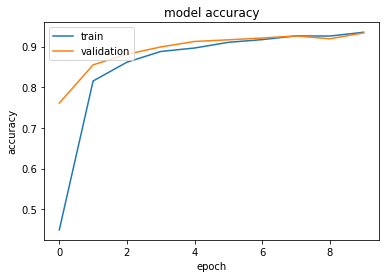

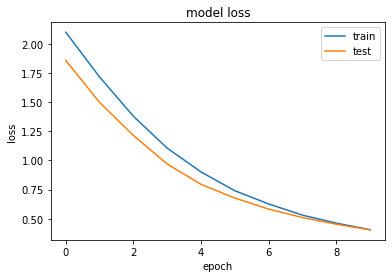

In [165]:
plot_hist(history)

# ذخیره مدل بر روی گوگل درایو

In [166]:
new_model.save('drive/My Drive/effnet_transfer_learning.h5')
loaded_model = keras.models.load_model('drive/My Drive/effnet_transfer_learning.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


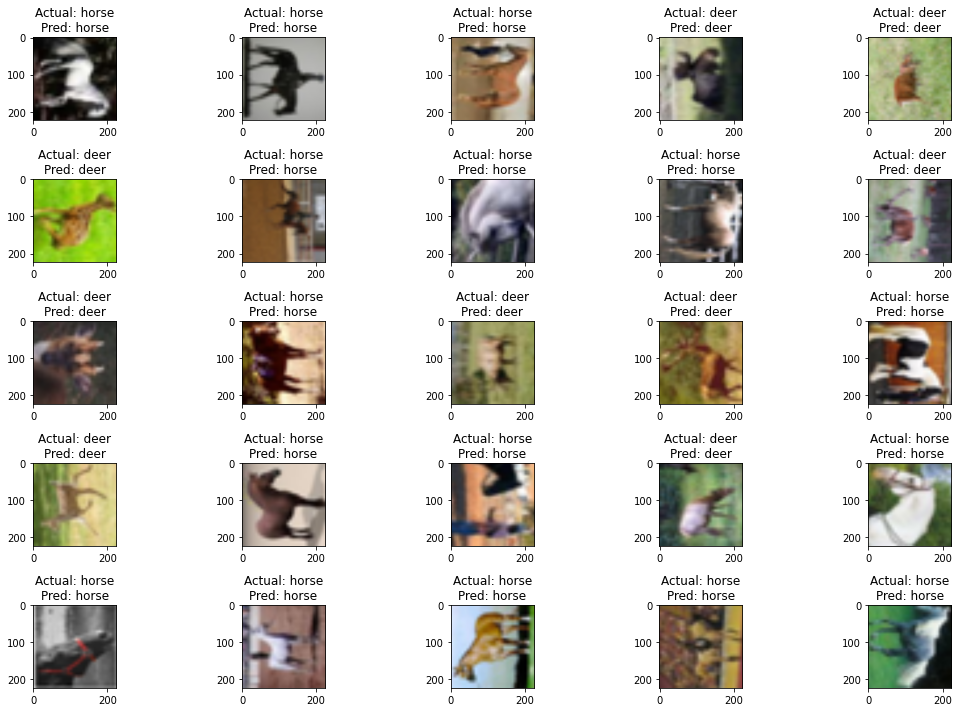

In [167]:
fig = plt.figure(figsize=(15, 10))

i = 1
for entry in test_set.take(25):
    pred = np.argmax(new_model.predict(entry[0].numpy()[0].reshape(1, 224, 224, 3)))

    sample_image = entry[0].numpy()[0]
    sample_label = 'deer' if entry[1].numpy()[0]==4 else 'horse' 

    prediction_label = 'deer' if pred==4 else 'horse'
    ax = fig.add_subplot(5, 5, i)
    

    ax.imshow(np.array(sample_image, np.int32))
    ax.set_title("Actual: %s\nPred: %s" % (sample_label, prediction_label))
    i = i+1

plt.tight_layout()
plt.show()

# ایجاد لایه های بیشتر جهت یادگیری با یک مدل جدید

In [169]:
for layer in loaded_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

for index, layer in enumerate(loaded_model.layers):
   print("Layer Index: {}, Trainable: {}, Layer Name : {} ".format(index, layer.trainable ,layer.name))

Layer Index: 0, Trainable: True, Layer Name : input_12 
Layer Index: 1, Trainable: True, Layer Name : rescaling_11 
Layer Index: 2, Trainable: True, Layer Name : normalization_11 
Layer Index: 3, Trainable: True, Layer Name : stem_conv_pad 
Layer Index: 4, Trainable: True, Layer Name : stem_conv 
Layer Index: 5, Trainable: False, Layer Name : stem_bn 
Layer Index: 6, Trainable: True, Layer Name : stem_activation 
Layer Index: 7, Trainable: True, Layer Name : block1a_dwconv 
Layer Index: 8, Trainable: False, Layer Name : block1a_bn 
Layer Index: 9, Trainable: True, Layer Name : block1a_activation 
Layer Index: 10, Trainable: True, Layer Name : block1a_se_squeeze 
Layer Index: 11, Trainable: True, Layer Name : block1a_se_reshape 
Layer Index: 12, Trainable: True, Layer Name : block1a_se_reduce 
Layer Index: 13, Trainable: True, Layer Name : block1a_se_expand 
Layer Index: 14, Trainable: True, Layer Name : block1a_se_excite 
Layer Index: 15, Trainable: True, Layer Name : block1a_project_c

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-6, decay=(1e-6/50))

loaded_model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer, 
                  metrics=["accuracy"])

history_loaded_model = loaded_model.fit(train_set, 
                        epochs=50,
                        validation_data=valid_set,
                        callbacks=[tensorboard_callback("Tensorboard","loaded_model"),
                                   model_checkpoint("Checkpoints","loaded_model.ckpt")])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.8791
Epoch 00001: val_accuracy improved from -inf to 0.90600, saving model to Checkpoints/loaded_model.ckpt
167/167 [==============================] - 1638s 10s/step - loss: 0.5698 - accuracy: 0.8791 - val_loss: 0.4806 - val_accuracy: 0.9060
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.9103
Epoch 00002: val_accuracy improved from 0.90600 to 0.91800, saving model to Checkpoints/loaded_model.ckpt
167/167 [==============================] - 1629s 10s/step - loss: 0.4235 - accuracy: 0.9103 - val_loss: 0.3957 - val_accuracy: 0.9180
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.9171
Epoch 00003: val_accuracy improved from 0.91800 to 0.92450, saving model to Checkpoints/loaded_model.ckpt
167/167 [==============================] - 1643s 10s/step - loss: 0.3710 - accuracy: 0.9171 - val_loss: 0.3514 - val_accuracy: 0.

# نمایش دقت مدل بر روی داده های تست

In [ ]:
score = loaded_model.evaluate(test_set)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# رسم نمودار دقت مدل

In [ ]:
plot_hist(history_loaded_model)

In [ ]:
fig = plt.figure(figsize=(15, 10))

i = 1
for entry in test_set.take(25):
    pred = np.argmax(loaded_model.predict(entry[0].numpy()[0].reshape(1, 224, 224, 3)))

    sample_image = entry[0].numpy()[0]
    sample_label = 'deer' if entry[1].numpy()[0]==4 else 'horse' 

    prediction_label = 'deer' if pred==4 else 'horse'
    ax = fig.add_subplot(5, 5, i)
    

    ax.imshow(np.array(sample_image, np.int32))
    ax.set_title("Actual: %s\nPred: %s" % (sample_label, prediction_label))
    i = i+1

plt.tight_layout()
plt.show()